#### Importando bibliotecas

In [1]:
# Importa todas as bibliotecas
import nibabel as nib
import numpy as np
import copy
import itertools
import os
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

#### Funções necessárias para armazenar os dados e rodar o modelo

In [2]:
# Funções para carregar as imagens já pré-processadas e calcular os labels
def calculate_label(image, threshold=0.04):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

def load_patient_data(folder, patient_id):
    """
    Carrega os dados de um único paciente (imagens, máscaras e labels) de um diretório.

    Args:
        folder (str): Caminho da pasta contendo os dados dos pacientes.
        patient_id (str): ID do paciente a ser carregado.

    Returns:
        dict: Dados do paciente, incluindo imagens, máscaras e labels para os lados esquerdo e direito.
              Retorna None se o paciente não for encontrado.
    """
    patient_path = os.path.join(folder, patient_id)
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()
            if len(data_left) > 0 or len(data_msk_left) > 0:
                patient_data["images_left"].append(data_left)
                patient_data["mask_left"].append(data_msk_left)
                patient_data["labels_left"].append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()
            if len(data_right) > 0 or len(data_msk_right) > 0:
                patient_data["images_right"].append(data_right)
                patient_data["mask_right"].append(data_msk_right)
                patient_data["labels_right"].append(calculate_label(data_msk_right))

    # Gera os pares de labels
    labels_pair = []
    for label_left, label_right in zip(patient_data["labels_left"], patient_data["labels_right"]):
        if label_left == 0 and label_right == 0:
            labels_pair.append(0)
        else:
            labels_pair.append(1)
    patient_data["labels_pair"] = labels_pair

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_pair)}")
    return patient_data, labels_pair

In [ ]:
# Função para normalizar entre 0 e 1
def normalize_minmax(image_data): 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

def augment_image(img_left, img_right, mask_left, mask_right):
    """
    Gera 7 variações (exceto a imagem original) aplicando:
    - rotação 180°
    - flip vertical
    - troca de lado
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.fliplr(img)

    results_left = []
    masks_left = []
    results_right = []
    masks_right = []
    
    # Todas as combinações possíveis, exceto a (False, False, False)
    for rotate in [False, True]:
        for flip in [False, True]:
            for swap in [False, True]:
                if not (rotate or flip or swap):  # pula a imagem padrão
                    continue

                l_img = img_left.copy()
                r_img = img_right.copy()
                l_mask = mask_left.copy()
                r_mask = mask_right.copy()

                if rotate:
                    l_img = rotate_180(l_img)
                    r_img = rotate_180(r_img)
                    l_mask = rotate_180(l_mask)
                    r_mask = rotate_180(r_mask)

                if flip:
                    l_img = flip_vertical(l_img)
                    r_img = flip_vertical(r_img)
                    l_mask = flip_vertical(l_mask)
                    r_mask = flip_vertical(r_mask)

                if swap:
                    l_img, r_img = r_img, l_img
                    l_mask, r_mask = r_mask, l_mask

                results_left.append(l_img)
                masks_left.append(l_mask)
                results_right.append(r_img)
                masks_right.append(r_mask)

    return results_left, results_right, masks_left, masks_right

def augment_single_image(img_left, img_right, mask_left, mask_right, rng):
    """
    Aplica uma única modificação aleatória entre:
    - rotação 180°
    - flip vertical
    - troca de lado
    - combinações entre elas
    (7 variações possíveis)
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.fliplr(img)

    # Lista de todas combinações possíveis (sem a identidade)
    transformations = [
        (True, False, False),   # só rotate
        (False, True, False),   # só flip
        (False, False, True),   # só swap
        (True, True, False),    # rotate + flip
        (True, False, True),    # rotate + swap
        (False, True, True),    # flip + swap
        (True, True, True)      # rotate + flip + swap
    ]

    # Escolhe aleatoriamente uma transformação
    rotate, flip, swap = rng.choice(transformations)

    l_img = img_left.copy()
    r_img = img_right.copy()
    l_mask = mask_left.copy()
    r_mask = mask_right.copy()

    if rotate:
        l_img = rotate_180(l_img)
        r_img = rotate_180(r_img)
        l_mask = rotate_180(l_mask)
        r_mask = rotate_180(r_mask)

    if flip:
        l_img = flip_vertical(l_img)
        r_img = flip_vertical(r_img)
        l_mask = flip_vertical(l_mask)
        r_mask = flip_vertical(r_mask)

    if swap:
        l_img, r_img = r_img, l_img
        l_mask, r_mask = r_mask, l_mask

    return l_img, r_img, l_mask, r_mask

# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = {}
    selected_images_opposite = {}
    selected_labels = []
    
    for patient in patients:
        selected_images_original[patient] = []
        selected_images_opposite[patient] = []
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original[patient].extend(all_images_original[patient])
            selected_images_opposite[patient].extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images_original, selected_images_opposite, selected_labels

In [89]:

# Função para preparar os dados para treino e validação
def prepare_data_for_training(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_left = {}
    balanced_images_right = {}
    balanced_labels = {}
    balanced_mask_left = {}
    balanced_mask_right = {}
    balanced_index_patients = {}

    # Separar os dados por conjunto (treino, validação, teste)
    train_patients = ['sub-02A13', 'sub-03C08', 'sub-06C09', 'sub-14F04', 'sub-16E03', 'sub-16G09', 'sub-16I12', 'sub-19F09', 'sub-19G04', 'sub-22F14', 'sub-26B09', 'sub-31F07', 'sub-35E12', 'sub-36K02', 'sub-41D08', 'sub-51C05', 'sub-52K04', 'sub-57D04', 'sub-59G00', 'sub-60G13', 'sub-60K04', 'sub-71C07', 'sub-72I02', 'sub-72K02', 'sub-76E02', 'sub-76J09', 'sub-83K08', 'sub-85I05', 'sub-86B13']
    valid_patients = ['sub-00H10', 'sub-25B08', 'sub-29D03', 'sub-34J06', 'sub-56E13', 'sub-59E09', 'sub-60G06', 'sub-79H07']
    test_patients = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']

    # patients = list(set(images_left.keys()))
    # train_patients, valtest_patients = train_test_split(patients, train_size = train_size+0.01)
    # valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
    
    print(len(train_patients) + len(valid_patients) + len(test_patients))
    
    class_1_left = {}
    class_0_left = {}
    class_1_right = {}
    class_0_right = {}
    class_1_mask_left = {}
    class_0_mask_left = {}
    class_1_mask_right = {}
    class_0_mask_right = {}
    class_1_coordinates = {}
    class_0_coordinates = {}
    
    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        class_1_coordinates[patient_id] = []
        class_0_coordinates[patient_id] = []
        index = 0
        seed = hash(patient_id) % (2**32)  # Gera uma seed única por paciente
        rng = np.random.default_rng(seed)
        
        if len(labels_pair[patient_id]) == 0:
            continue
        
        if patient_id in test_patients:
            balanced_images_left[patient_id] = images_left[patient_id]
            balanced_images_right[patient_id] = images_right[patient_id]
            balanced_labels[patient_id] = labels_pair[patient_id]
            balanced_mask_left[patient_id] = mask_left[patient_id]
            balanced_mask_right[patient_id] = mask_right[patient_id]
            continue
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com label 1: {class_1_count}")
        class_0_count = len(class_0_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com label 0: {class_0_count}")

        # Fazer Uppersampling da classe minoritária (label 1) para igualar ao número de exemplos da classe 0
        print(f"Paciente {patient_id}: Total de patches classe 1 antes do uppersampling: {class_1_count}")
        
        # Se a classe 1 for menor, aplicamos data augmentation
        if class_1_count < class_0_count:
            augmented_images_left = []
            augmented_images_right = []
            augmented_masks_left = []
            augmented_masks_right = []

            for idx, elem in enumerate(class_1_left[patient_id]):
                imgs_left_aug, imgs_right_aug, masks_left_aug, masks_right_aug = augment_image(class_0_left[patient_id][idx], class_0_right[patient_id][idx], class_0_mask_left[patient_id][idx], class_0_mask_right[patient_id][idx])
            
                augmented_images_left.extend(imgs_left_aug)
                augmented_images_right.extend(imgs_right_aug)
                augmented_masks_left.extend(masks_left_aug)
                augmented_masks_right.extend(masks_right_aug)

            # Adiciona os dados aumentados
            class_1_left[patient_id].extend(augmented_images_left)
            class_1_right[patient_id].extend(augmented_images_right)
            class_1_mask_left[patient_id].extend(augmented_masks_left)
            class_1_mask_right[patient_id].extend(augmented_masks_right)
            class_1_labels.extend([1] * (class_1_count*7))
            
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de patches classe 1 depois do uppersampling: {class_1_count}")
        
        augmented_class_0_left = []
        augmented_class_0_right = []
        augmented_class_0_mask_left = []
        augmented_class_0_mask_right = []

        i=0
        for img_left, img_right, mask_l, mask_r in zip(class_0_left[patient_id], class_0_right[patient_id], class_0_mask_left[patient_id], class_0_mask_right[patient_id]):
            # Decide aleatoriamente se vai aplicar augmentação
            seed = (hash(patient_id)+i) % (2**32)  # Gera uma seed única por paciente
            rng2 = np.random.default_rng(seed)
            if rng2.choice(2, 1, replace=False) < 1:
                aug_l, aug_r, aug_mask_l, aug_mask_r = augment_single_image(img_left, img_right, mask_l, mask_r, rng)
                augmented_class_0_left.append(aug_l)
                augmented_class_0_right.append(aug_r)
                augmented_class_0_mask_left.append(aug_mask_l)
                augmented_class_0_mask_right.append(aug_mask_r)
            else:
                # Mantém a original
                augmented_class_0_left.append(img_left)
                augmented_class_0_right.append(img_right)
                augmented_class_0_mask_left.append(mask_l)
                augmented_class_0_mask_right.append(mask_r)
            i+=1

        # Atualiza as listas da classe 0 com as versões modificadas
        class_0_left[patient_id] = augmented_class_0_left
        class_0_right[patient_id] = augmented_class_0_right
        class_0_mask_left[patient_id] = augmented_class_0_mask_left
        class_0_mask_right[patient_id] = augmented_class_0_mask_right
        
        # Fazer undersampling aleatório da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            sampled_indices = rng.choice(len(class_0_left[patient_id]), class_1_count, replace=False)
            sampled_class_0_slices_left = [class_0_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_slices_right = [class_0_right[patient_id][i] for i in sampled_indices]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            sampled_class_0_mask_left = [class_0_mask_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_mask_right = [class_0_mask_right[patient_id][i] for i in sampled_indices]
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []
            
            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_left = class_0_original_modified
            class_0_right = class_0_opposite_modified
            class_0_mask_left = class_0_mask_original_modified
            class_0_mask_right = class_0_mask_opposite_modified
            class_0_labels = [0] * (class_1_count)
        else:
            sampled_indices = rng.choice(len(class_1_left[patient_id]), class_0_count, replace=False)
            sampled_class_1_slices_left = [class_1_left[patient_id][i] for i in sampled_indices]
            sampled_class_1_slices_right = [class_1_right[patient_id][i] for i in sampled_indices]
            class_1_original_modified = {}
            class_1_original_modified[patient_id] = []
            class_1_opposite_modified = {}
            class_1_opposite_modified[patient_id] = []
            sampled_class_1_mask_left = [class_1_mask_left[patient_id][i] for i in sampled_indices]
            sampled_class_1_mask_right = [class_1_mask_right[patient_id][i] for i in sampled_indices]
            class_1_mask_original_modified = {}
            class_1_mask_original_modified[patient_id] = []
            class_1_mask_opposite_modified = {}
            class_1_mask_opposite_modified[patient_id] = []

            for left_image, left_mask in zip(sampled_class_1_slices_left, sampled_class_1_mask_left):
                class_1_original_modified[patient_id].append(left_image)
                class_1_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_1_slices_right, sampled_class_1_mask_right):
                class_1_opposite_modified[patient_id].append(right_image)
                class_1_mask_opposite_modified[patient_id].append(right_mask)
            class_1_left = class_1_original_modified
            class_1_right = class_1_opposite_modified
            class_1_mask_left = class_1_mask_original_modified
            class_1_mask_right = class_1_mask_opposite_modified
            class_1_labels = [1] * (class_0_count)
        
        print(len(class_1_left[patient_id]))
        print(len(class_1_right[patient_id]))
        print(len(class_1_labels))
        
        balanced_images_left[patient_id] = class_1_left[patient_id][:] + class_0_left[patient_id][:]
        balanced_images_right[patient_id] = class_1_right[patient_id][:] + class_0_right[patient_id][:]
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_left[patient_id] = class_1_mask_left[patient_id][:] + class_0_mask_left[patient_id][:]
        balanced_mask_right[patient_id] = class_1_mask_right[patient_id][:] + class_0_mask_right[patient_id][:]
        
        balanced_index = rng.choice(range(len(balanced_labels[patient_id])), len(balanced_labels[patient_id]), replace=False)            
        balanced_images_left[patient_id] = [balanced_images_left[patient_id][i] for i in balanced_index]
        balanced_images_right[patient_id] = [balanced_images_right[patient_id][i] for i in balanced_index]
        balanced_labels[patient_id] = [balanced_labels[patient_id][i] for i in balanced_index]
        balanced_mask_left[patient_id] = [balanced_mask_left[patient_id][i] for i in balanced_index]
        balanced_mask_right[patient_id] = [balanced_mask_right[patient_id][i] for i in balanced_index]
        balanced_index_patients[patient_id] = balanced_index
    
        class_1_count = len(class_1_labels)
        class_0_count = len(class_0_labels)
        print(f"Paciente {patient_id}: Total de patches no final: {class_1_count+class_0_count}")

    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_left, balanced_images_right, balanced_labels)
    
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, X_test_original, X_test_opposite, np.array(y_train), np.array(y_val), np.array(y_test), train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients

def prepare_data_aligned(images_left, images_right, labels_pair, mask_left, mask_right):
    patients = list(images_left.keys())

    # Separar os dados por conjunto (treino, validação, teste)
    train_patients_split = ['sub-02A13', 'sub-03C08', 'sub-06C09', 'sub-14F04', 'sub-16E03', 'sub-16G09', 'sub-16I12', 'sub-19F09', 'sub-19G04', 'sub-22F14', 'sub-26B09', 'sub-31F07', 'sub-35E12', 'sub-36K02', 'sub-41D08', 'sub-51C05', 'sub-52K04', 'sub-57D04', 'sub-59G00', 'sub-60G13', 'sub-60K04', 'sub-71C07', 'sub-72I02', 'sub-72K02', 'sub-76E02', 'sub-76J09', 'sub-83K08', 'sub-85I05', 'sub-86B13']
    val_patients_split = ['sub-00H10', 'sub-25B08', 'sub-29D03', 'sub-34J06', 'sub-56E13', 'sub-59E09', 'sub-60G06', 'sub-79H07']
    test_patients_split = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']
    
    # Separar patches de cada paciente com seus respectivos indices
    patches_per_patient = {}
    for patient in patients:
        patches_per_patient[patient] = []
        for idx, label in enumerate(labels_pair[patient]):
            patch_info = {
                'index': idx,
                'image_left': images_left[patient][idx],
                'image_right': images_right[patient][idx],
                'mask_left': mask_left[patient][idx],
                'mask_right': mask_right[patient][idx],
                'label': label
            }
            patches_per_patient[patient].append(patch_info)

    paired_displasia = []
    paired_saudavel = []

    patient_ids = sorted(patients)  # Ordenar para garantir determinismo
    for i in patient_ids:
        if i in test_patients_split:
            patient_ids.remove(i)
    
    for patient in test_patients_split:
        for patch in patches_per_patient[patient]:
            if patch['label'] == 1:
                paired_displasia.append((patient, patch))
            else:
                paired_saudavel.append((patient, patch))

    
    for i in range(len(patient_ids) - 1):
        patient_current = patient_ids[i]
        patient_next = patient_ids[i+1]

        patches_current = patches_per_patient[patient_current]
        patches_next = patches_per_patient[patient_next]

        displasia_indices = [p['index'] for p in patches_current if p['label'] == 1]

        if not displasia_indices:
            print(f"Paciente {patient_current} sem regiões de displasia.")
            continue

        min_idx = min(displasia_indices)
        max_idx = max(displasia_indices)

        print(f"Paciente {patient_current} displasia de {min_idx} a {max_idx}.")

        for idx in range(min_idx, max_idx+1):
            if idx < len(patches_current):
                paired_displasia.append((patient_current, patches_current[idx]))

        valid_saudavel = True
        for idx in range(min_idx, max_idx+1):
            if idx >= len(patches_next) or patches_next[idx]['label'] == 1:
                valid_saudavel = False
                break

        if valid_saudavel:
            for idx in range(min_idx, max_idx+1):
                paired_saudavel.append((patient_next, patches_next[idx]))
        else:
            print(f"Conflito de indices no paciente {patient_next}, randomizando saudáveis.")
            saudaveis = [p for p in patches_next if p['label'] == 0]
            rng = np.random.default_rng(hash(patient_current + patient_next) % (2**32))
            selected = rng.choice(saudaveis, size=(max_idx - min_idx + 1), replace=True)
            for s in selected:
                paired_saudavel.append((patient_next, s))

    all_data = paired_displasia + paired_saudavel

    # Agrupar por paciente
    data_by_patient = {}
    for patient, patch in all_data:
        if patient not in data_by_patient:
            data_by_patient[patient] = []
        data_by_patient[patient].append(patch)

    def collect_data(patient_split, boolean):
        X_left, X_right, y = [], [], []
        for patient in patient_split:
            for patch in data_by_patient[patient]:
                X_left.append(patch['image_left'])
                X_right.append(patch['image_right'])
                y.append(patch['label'])
        if boolean:  
            # Aplicar undersampling
            indices_class_1 = [i for i, label in enumerate(y) if label == 1]
            indices_class_0 = [i for i, label in enumerate(y) if label == 0]
            
            min_class = min(len(indices_class_1), len(indices_class_0))
            
            # Subamostrar para balancear
            selected_indices_class_1 = rng.choice(indices_class_1, min_class, replace=False)
            selected_indices_class_0 = rng.choice(indices_class_0, min_class, replace=False)
            
            selected_indices = np.concatenate((selected_indices_class_1, selected_indices_class_0))
            rng.shuffle(selected_indices)
            
            X_left_balanced = [X_left[i] for i in selected_indices]
            X_right_balanced = [X_right[i] for i in selected_indices]
            y_balanced = [y[i] for i in selected_indices]
            
            X_left = X_left_balanced
            X_right = X_right_balanced
            y = y_balanced
            
        return X_left, X_right, y


    X_train_original, X_train_opposite, y_train = collect_data(train_patients_split, True)
    X_val_original, X_val_opposite, y_val = collect_data(val_patients_split, True)
    X_test_original, X_test_opposite, y_test = collect_data(test_patients_split, False)

    print(f"Total de pares de recortes no treino com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com label 0: {y_test.count(0)}")

    return (np.array(X_train_original), np.array(X_train_opposite),
            np.array(X_val_original), np.array(X_val_opposite),
            np.array(X_test_original), np.array(X_test_opposite),
            np.array(y_train), np.array(y_val), np.array(y_test),
            train_patients_split, val_patients_split, test_patients_split)


In [5]:
# Função para construir o modelo CNN 2D
def build_cnn_model_backup():
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(16, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    # model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Dropout(0.3)) 
     
    model.add(layers.Conv2D(32, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    # model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())

    return model

In [6]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape):
    input_original = Input(shape=input_shape)
    input_opposite = Input(shape=input_shape)

    # Criar a CNN base compartilhada
    cnn_base = build_cnn_model_backup()
    
    # Aplicar a mesma CNN base para ambas as entradas
    output_original = cnn_base(input_original)
    output_opposite = cnn_base(input_opposite)

    # Calcula a diferença absoluta
    # l1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([output_original, output_opposite])

    # Subtrair as duas saídas (Lado esquerdo - Contra-lateral)
    subtracted = layers.Subtract()([output_original, output_opposite])
    subtracted = layers.BatchNormalization()(subtracted)

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    # concatenated = layers.Concatenate()([output_original, output_opposite])
    # concatenated = layers.BatchNormalization()(concatenated)
    
    # Passar o resultado pela rede densa
    subtracted = layers.Dense(64, activation='relu')(subtracted)
    subtracted = layers.Dropout(0.3)(subtracted)
    subtracted = layers.Dense(32, activation='relu')(subtracted)
    subtracted = layers.Dropout(0.3)(subtracted)

    output = layers.Dense(1, activation='sigmoid')(subtracted)

    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

    return siamese_model


In [7]:
# Função de plot do treinamento do modelo
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [8]:
# Função de plot da matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


#### Rodando função de Pré-Processamento

In [10]:
# Caminho da pasta contendo os dados dos pacientes
folder = "Novo_Contralateral"

# Lista de IDs dos pacientes
patient_ids = os.listdir(folder)

X_left, X_right, y, mask_left, mask_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in patient_ids:
    # Carrega os dados do paciente
    patient_data, labels_pair = load_patient_data(folder, patient_id)
    
    if patient_data is not None:
        X_left[patient_id] = patient_data["images_left"]
        X_right[patient_id] = patient_data["images_right"]
        mask_left[patient_id] = patient_data["mask_left"]
        mask_right[patient_id] = patient_data["mask_right"]
        y[patient_id] = labels_pair

Paciente sub-00H10 carregado com sucesso.
Total de recortes: 1134
Paciente sub-02A13 carregado com sucesso.
Total de recortes: 1150
Paciente sub-03C08 carregado com sucesso.
Total de recortes: 1013
Paciente sub-06C09 carregado com sucesso.
Total de recortes: 1122
Paciente sub-14F04 carregado com sucesso.
Total de recortes: 1187
Paciente sub-16E03 carregado com sucesso.
Total de recortes: 1263
Paciente sub-16G09 carregado com sucesso.
Total de recortes: 1136
Paciente sub-16I12 carregado com sucesso.
Total de recortes: 1209
Paciente sub-19F09 carregado com sucesso.
Total de recortes: 1229
Paciente sub-19G04 carregado com sucesso.
Total de recortes: 1134
Paciente sub-22F14 carregado com sucesso.
Total de recortes: 1156
Paciente sub-25B08 carregado com sucesso.
Total de recortes: 1229
Paciente sub-26B09 carregado com sucesso.
Total de recortes: 1185
Paciente sub-29D03 carregado com sucesso.
Total de recortes: 1106
Paciente sub-31F07 carregado com sucesso.
Total de recortes: 1132
Paciente s

In [90]:
# Preparar dados para treino, validação e teste
# train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, test_left, test_right, y_train_balanced, y_valid_balanced, y_test, train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients = prepare_data_for_training(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)
train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, test_left, test_right, y_train_balanced, y_valid_balanced, y_test, train_patients, valid_patients, test_patients = prepare_data_aligned(X_left, X_right, y, mask_left, mask_right)

Paciente sub-00H10 displasia de 839 a 899.
Conflito de indices no paciente sub-02A13, randomizando saudáveis.
Paciente sub-02A13 displasia de 492 a 941.
Conflito de indices no paciente sub-03C08, randomizando saudáveis.
Paciente sub-03C08 displasia de 241 a 590.
Conflito de indices no paciente sub-06C09, randomizando saudáveis.
Paciente sub-06C09 displasia de 267 a 357.
Paciente sub-14F04 displasia de 872 a 940.
Paciente sub-16E03 displasia de 49 a 379.
Paciente sub-16G09 displasia de 801 a 1033.
Paciente sub-16I12 displasia de 325 a 622.
Conflito de indices no paciente sub-19F09, randomizando saudáveis.
Paciente sub-19F09 displasia de 75 a 653.
Conflito de indices no paciente sub-19G04, randomizando saudáveis.
Paciente sub-19G04 displasia de 53 a 145.
Paciente sub-22F14 displasia de 656 a 878.
Conflito de indices no paciente sub-25B08, randomizando saudáveis.
Paciente sub-25B08 displasia de 386 a 722.
Conflito de indices no paciente sub-26B09, randomizando saudáveis.
Paciente sub-26B0

In [91]:
# Adiciono camada de cor
# train_left_balanced = normalize_minmax(np.array([elemento for lista in train_left_balanced.values() for elemento in lista]))
train_left_balanced = np.expand_dims(train_left_balanced, axis=-1)
# train_right_balanced = normalize_minmax(np.array([elemento for lista in train_right_balanced.values() for elemento in lista]))
train_right_balanced = np.expand_dims(train_right_balanced, axis=-1)
# valid_left_balanced = normalize_minmax(np.array([elemento for lista in valid_left_balanced.values() for elemento in lista]))
valid_left_balanced = np.expand_dims(valid_left_balanced, axis=-1)
# valid_right_balanced = normalize_minmax(np.array([elemento for lista in valid_right_balanced.values() for elemento in lista]))
valid_right_balanced = np.expand_dims(valid_right_balanced, axis=-1)
# test_left = normalize_minmax(np.array([elemento for lista in test_left.values() for elemento in lista]))
test_left = np.expand_dims(test_left, axis=-1)
# test_right = normalize_minmax(np.array([elemento for lista in test_right.values() for elemento in lista]))
test_right = np.expand_dims(test_right, axis=-1)

#### Rodando modelo e printando resultados sem Pós-Processamento

In [92]:
        # Construir e compilar o modelo CNN
input_shape = (train_left_balanced[0].shape)

siamese_model = build_siamese_model(input_shape)
siamese_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 sequential_7 (Sequential)   (None, 2304)                 24864     ['input_15[0][0]',            
                                                                     'input_16[0][0]']            
                                                                                                  
 subtract_6 (Subtract)       (None, 2304)                 0         ['sequential_7[0][0]',  

In [93]:
# Adicionar o callback EarlyStopping e low rate scheduler
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# Ajusta learning rate
# reduce_lr = callbacks.ReduceLROnPlateau(factor=0.8, patience=15, verbose=1)

# Suponha que seus rótulos estejam em y_train_balanced
# classes = np.unique(y_valid_balanced)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_valid_balanced)
# class_weight_dict = dict(zip(classes, weights))

# Salvar a melhor epoca
checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True,  save_weights_only=True, mode='min')

# Treinamento do modelo siames
history = siamese_model.fit([train_left_balanced, train_right_balanced], y_train_balanced, validation_data=([valid_left_balanced, valid_right_balanced], y_valid_balanced), batch_size=128, epochs=150, callbacks=[checkpoint])

Epoch 1/150
34/34 [==============================] - 9s 161ms/step - loss: 0.7693 - accuracy: 0.5268 - precision: 0.5301 - recall: 0.4725 - val_loss: 0.6878 - val_accuracy: 0.5577 - val_precision: 0.5580 - val_recall: 0.5544
Epoch 2/150
34/34 [==============================] - 4s 129ms/step - loss: 0.7234 - accuracy: 0.5404 - precision: 0.5473 - recall: 0.4679 - val_loss: 0.6965 - val_accuracy: 0.5033 - val_precision: 0.5024 - val_recall: 0.6855
Epoch 3/150
34/34 [==============================] - 5s 138ms/step - loss: 0.6988 - accuracy: 0.5598 - precision: 0.5681 - recall: 0.4993 - val_loss: 0.6935 - val_accuracy: 0.5229 - val_precision: 0.5170 - val_recall: 0.6959
Epoch 4/150
34/34 [==============================] - 4s 130ms/step - loss: 0.6836 - accuracy: 0.5617 - precision: 0.5692 - recall: 0.5072 - val_loss: 0.6946 - val_accuracy: 0.5275 - val_precision: 0.5168 - val_recall: 0.8467
Epoch 5/150
34/34 [==============================] - 5s 137ms/step - loss: 0.6765 - accuracy: 0.5746

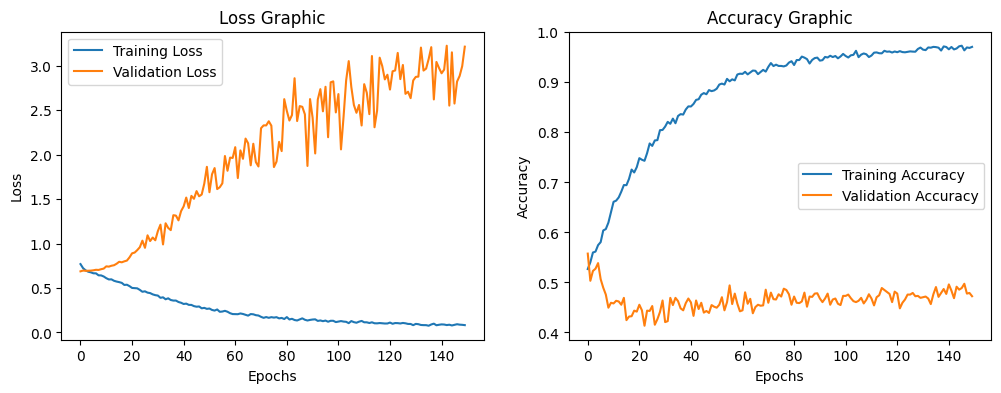

In [94]:
# Plotar o histórico do treinamento
plot_training_history(history)

178/178 [==============================] - 2s 10ms/step


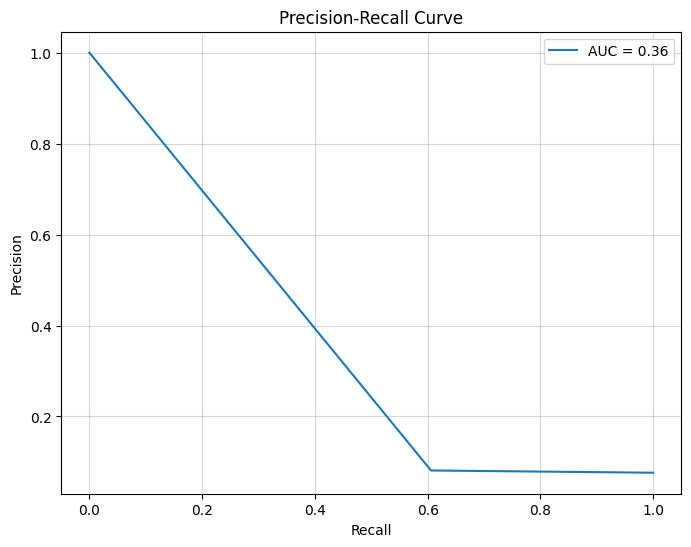

In [95]:
# Carregando pesos da melhor época
siamese_model.load_weights('best_model.h5')

# Avaliar o modelo na validação
y_pred_train = (siamese_model.predict([train_left_balanced, train_right_balanced]) > 0.5).astype(int)

# Avaliar o modelo na validação
y_pred_valid = (siamese_model.predict([valid_left_balanced, valid_right_balanced]) > 0.5).astype(int)

# Avaliar o modelo no teste
y_pred_test = (siamese_model.predict([test_left, test_right]) > 0.5).astype(int)

# Calcula a curva precision-recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)

# Calcula a AUC precision-recall
auc_pr = auc(recall, precision)

# Plote a curva precision-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()

In [96]:
# Gerar o relatório de classificação
print("Validação:")
print(classification_report(y_valid_balanced, y_pred_valid))
print("\n#########################################################\n")
print("Teste:")
#print(classification_report(y_test, y_pred_test)) 
print(classification_report(y_test, y_pred_test)) 

Validação:
              precision    recall  f1-score   support

           0       0.56      0.56      0.56       763
           1       0.56      0.55      0.56       763

    accuracy                           0.56      1526
   macro avg       0.56      0.56      0.56      1526
weighted avg       0.56      0.56      0.56      1526


#########################################################

Teste:
              precision    recall  f1-score   support

           0       0.93      0.43      0.59      5261
           1       0.08      0.61      0.14       434

    accuracy                           0.45      5695
   macro avg       0.51      0.52      0.37      5695
weighted avg       0.87      0.45      0.56      5695



Validação:


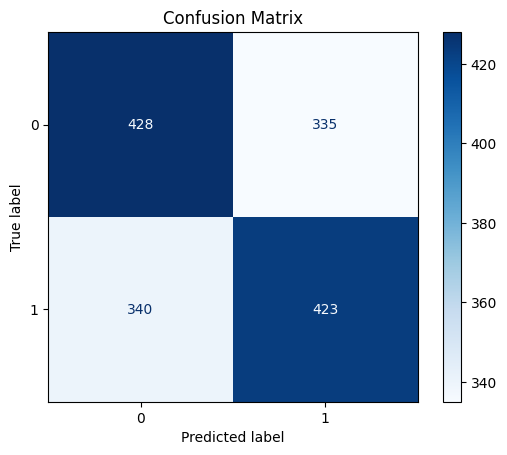


#########################################################

Teste:


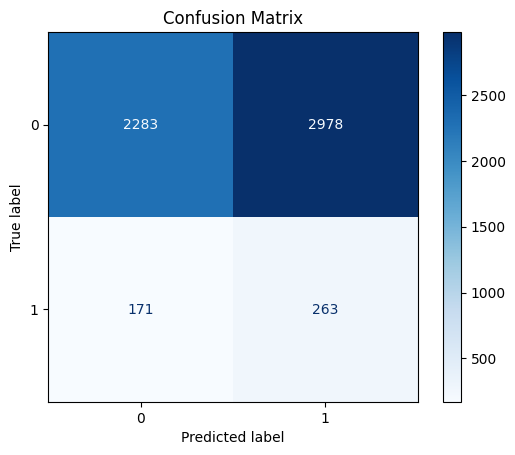

In [97]:
# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(y_valid_balanced, y_pred_valid)
print("\n#########################################################\n")
print("Teste:")
#plot_confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(y_test, y_pred_test)

##### Rodando processos de Pós-Processamento

In [98]:
def load_patient_data_per_slice(folder, patient_id): # carregar dados de teste, mantendo os dados de cada fatia em um vetor
    patient_path = os.path.join(folder, patient_id)  # folder/patient/
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    labels_total = []
    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])  # folder/patient/left
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)  # folder/patient/left/slice_
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)
        
        slice_left_img = []
        slice_right_img = []
        slice_left_mask = []
        slice_right_mask = []
        slice_left_labels = []
        slice_right_labels = []

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()

            if len(data_left) > 0 or len(data_msk_left) > 0:
                slice_left_img.append(data_left)
                slice_left_mask.append(data_msk_left)
                slice_left_labels.append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()

            if len(data_right) > 0 or len(data_msk_right) > 0:
                slice_right_img.append(data_right)
                slice_right_mask.append(data_msk_right)
                slice_right_labels.append(calculate_label(data_msk_right))

        patient_data["images_left"].append(slice_left_img)
        patient_data["mask_left"].append(slice_left_mask)
        patient_data["labels_left"].append(slice_left_labels)

        patient_data["images_right"].append(slice_right_img)
        patient_data["mask_right"].append(slice_right_mask)
        patient_data["labels_right"].append(slice_right_labels)

        labels_pair = []
        for label_left, label_right in zip(slice_left_labels, slice_right_labels):
            if label_left == 0 and label_right == 0:
                labels_pair.append(0)
            else:
                labels_pair.append(1)
        labels_total.append(labels_pair)

    patient_data["labels_pair"] = labels_total

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_total)}")
    return patient_data, labels_total

def test_labels_near(predictions): # pós-processamento
    new_pred = copy.deepcopy(predictions)
    previous_pos = 0
    actual_pos = 0
    next_pos = 0

    for i in range(1, len(predictions) - 1):

        # testa posições "perto", mas tá errado pela ordem dos recortes dentro da fatia
        for j in range(1, len(predictions[i])-1):
            if predictions[i][j] == 0 and predictions[i][j-1] == 1 and predictions[i][j+1] == 1:
                new_pred[i][j+1] = 0
                new_pred[i][j-1] = 0
                print(f"ANTES unit: {predictions[i]}")
                print(f"DEPOIS: {new_pred[i]}\n")

        # testa 3 fatias sequenciais
        previous_pos = np.count_nonzero(predictions[i - 1])
        actual_pos = np.count_nonzero(predictions[i])
        next_pos = np.count_nonzero(predictions[i + 1])

        if (previous_pos == 0 and actual_pos >= 1 and next_pos == 0):
            new_pred[i] = np.array([0 for j in range(len(predictions[i]))])
            print(f"ANTES whole: {predictions[i]}")
            print(f"DEPOIS: {new_pred[i]}\n")

    return new_pred

In [ ]:
# Caminho da pasta contendo os dados dos pacientes
folder = "Novo_Contralateral"

# Lista de IDs dos pacientes
test_patient_ids = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']

X_slices_left, X_slices_right, y_slices, mask_slices_left, mask_slices_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in test_patient_ids:
    # Carrega os dados do paciente
    patient_data_test, labels_pair_test = load_patient_data_per_slice(folder, patient_id)
    
    if patient_data_test is not None:
        X_slices_left[patient_id] = patient_data_test["images_left"]
        X_slices_right[patient_id] = patient_data_test["images_right"]
        mask_slices_left[patient_id] = patient_data_test["mask_left"]
        mask_slices_right[patient_id] = patient_data_test["mask_right"]
        y_slices[patient_id] = labels_pair_test

Paciente sub-42B05 carregado com sucesso.
Total de recortes: 139
Paciente sub-42K06 carregado com sucesso.
Total de recortes: 132
Paciente sub-44H05 carregado com sucesso.
Total de recortes: 142


In [ ]:
# Normalização e tratamento de dimensões do dado de teste
test_single_left = {}
test_single_right = {}

for id in test_patient_ids:
    test_single_left[id] = []
    test_single_right[id] = []

    for i in range(0, len(X_slices_left[id])):
        test_single_left[id].append([])
        test_single_right[id].append([])

        for j in range(0, len(X_slices_left[id][i])):
            # print(f"Dados do paciente {id} da fatia {i} do dado {j} esquerdo")
            test_single_left[id][i].append(normalize_minmax(np.array(X_slices_left[id][i][j]))) # normaliza as imagens
            test_single_right[id][i].append(normalize_minmax(np.array(X_slices_right[id][i][j])))

        test_single_left[id][i] = np.expand_dims(test_single_left[id][i], axis=-1) # expande eixo pra passar rede pra predict
        test_single_right[id][i] = np.expand_dims(test_single_right[id][i], axis=-1)

In [59]:
# Construir e compilar o modelo CNN
input_shape = (test_single_left[test_patient_ids[0]][0][0].shape)

siamese_model = build_siamese_model(input_shape)
siamese_model.summary()

# Carregando pesos da melhor época
siamese_model.load_weights('best_model.h5')

y_test_slices_pred = {}

for patient in test_patient_ids:
    print(f"paciente {patient}")
    y_test_slices_pred[patient] = []

    for i in range(0, len(X_slices_left[patient])):
        print(f"fatia {i}")
        left = test_single_left[patient][i]
        right = test_single_right[patient][i]
        y_test_slices_pred[patient].append((siamese_model.predict([left, right]) > 0.5).astype(int).flatten())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 2304)                 24864     ['input_9[0][0]',             
                                                                     'input_10[0][0]']            
                                                                                                  
 subtract_4 (Subtract)       (None, 2304)                 0         ['sequential_4[0][0]',  

#### Comparando resultados sem e com Pós-Processamento

In [ ]:
# labels certos -> y_slices
# predição não processada -> y_test_slices_pred
# predição processada -> processed labels

processed_labels = {}

# crio um novo vetor com os labels processados
for patient_name in test_patient_ids:
    processed_labels[patient_name] = test_labels_near(y_test_slices_pred[patient_name])


ANTES unit: [0 1 0 1]
DEPOIS: [0 0 0 0]

ANTES unit: [0 1 0 1]
DEPOIS: [0 0 0 0]

ANTES unit: [0 1 0 1]
DEPOIS: [0 0 0 0]

ANTES unit: [1 1 0 1]
DEPOIS: [1 0 0 0]

ANTES unit: [0 1 0 1]
DEPOIS: [0 0 0 0]

ANTES unit: [0 1 0 1]
DEPOIS: [0 0 0 0]

ANTES unit: [1 1 0 1]
DEPOIS: [1 0 0 0]

ANTES unit: [0 1 0 1]
DEPOIS: [0 0 0 0]

ANTES unit: [1 1 0 1]
DEPOIS: [1 0 0 0]

ANTES unit: [1 1 0 1]
DEPOIS: [1 0 0 0]

ANTES unit: [1 1 1 0 1]
DEPOIS: [1 1 0 0 0]

ANTES unit: [1 1 1 1 0 1]
DEPOIS: [1 1 1 0 0 0]

ANTES unit: [1 1 1 1 0 1]
DEPOIS: [1 1 1 0 0 0]

ANTES unit: [1 1 1 0 1 1]
DEPOIS: [1 1 0 0 0 1]

ANTES unit: [1 1 1 0 1 1]
DEPOIS: [1 1 0 0 0 1]

ANTES unit: [1 1 1 0 1 1]
DEPOIS: [1 1 0 0 0 1]

ANTES unit: [1 0 1 1 0 1 1]
DEPOIS: [0 0 0 1 0 1 1]

ANTES unit: [1 0 1 1 0 1 1]
DEPOIS: [0 0 0 0 0 0 1]

ANTES unit: [1 1 1 1 0 1 1]
DEPOIS: [1 1 1 0 0 0 1]

ANTES unit: [1 1 1 1 0 1 1]
DEPOIS: [1 1 1 0 0 0 1]

ANTES unit: [1 0 1 1 0 0 1 1]
DEPOIS: [0 0 0 1 0 0 1 1]

ANTES unit: [1 0 1 1 0 0 1 1]
D

RESULTADO ORIGINAL:


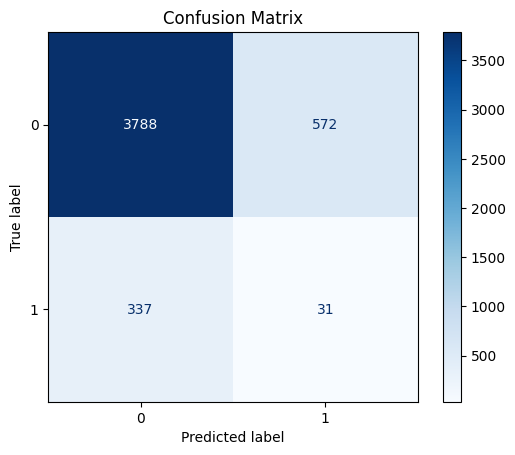


#########################################################

PÓS PROCESSADO:


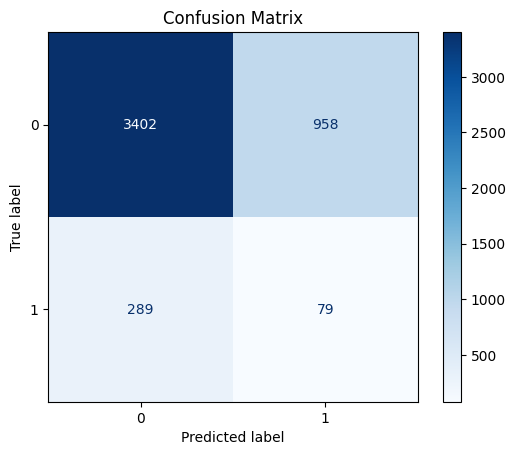

In [ ]:
labels_pred_processed = list(itertools.chain(*list(itertools.chain(*processed_labels.values()))))

# Gerar a matriz de confusão
print("RESULTADO ORIGINAL:")
plot_confusion_matrix(y_test, y_pred_test)
print("\n#########################################################\n")
print("PÓS PROCESSADO:")
plot_confusion_matrix(y_test, labels_pred_processed)

# print(labels_true)
# print(labels_pred_raw)
# print(labels_pred_processed)

# print(np.count_nonzero(labels_true))
# print(np.count_nonzero(labels_pred_raw))
# print(np.count_nonzero(labels_pred_processed))

In [ ]:
print("Teste") 
print(classification_report(y_test, labels_pred_processed)) 

Teste
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4360
           1       0.08      0.21      0.11       368

    accuracy                           0.74      4728
   macro avg       0.50      0.50      0.48      4728
weighted avg       0.86      0.74      0.79      4728



#### Plotando PDFs para comparação dos resultados e análise das classificações

In [ ]:
# Função para adicionar borda ao patch com a cor da classificação
def add_border(image, color, thickness=3):
    image_normalized = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image_rgb = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2RGB)
    bordered_image = cv2.copyMakeBorder(image_rgb, thickness, thickness, thickness, thickness, cv2.BORDER_CONSTANT, value=color)
    return bordered_image

# Função para carregar imagens no formato NIfTI (.nii.gz)
def load_nii_slice(patient_id, slice_index, base_path):
    file_path = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.nii.gz")
    if os.path.exists(file_path):
        nii_img = nib.load(file_path)
        img_data = nii_img.get_fdata()
        return img_data
    return None

# Função para carregar coordenadas de arquivos .txt
def load_coordinates(patient_id, slice_index, base_path):
    coord_file = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.txt")
    if os.path.exists(coord_file):
        with open(coord_file, "r") as file:
            coordinates = [tuple(map(int, line.strip().split(","))) for line in file]
        return coordinates
    return []

# Função para reconstruir a imagem e sobrepor o grid
def build_image_with_grid(patient_id, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index):
    img = load_nii_slice(patient_id, slice_index, image_path)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)
    
    if img is None or mask is None or not coordinates:
        return None, None, index
    
    reconstructed_img = np.zeros((233, 197, 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((233, 197, 3), dtype=np.uint8)
    
    colors = {"TP": (0, 255, 0), "TN": (150, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
    classifications = []
    classifications_right = []
    
    # Determinar a classificação de cada patch
    half = len(coordinates) // 2

    if half == 1:
        axs = [axs]  # Handle single patch pair case

    for i in range(half):
        if labels_pred[i+index] == labels_true[i+index]:
            if labels_pred[i+index] == 1:
                classification = "TP"
            else:
                classification = "TN"
        else:
            if labels_pred[i+index] == 1:
                classification = "FP"
            else:
                classification = "FN"
        classifications.append(classification)
        classifications_right.append(classification)
        
    # Sincronizar classificações entre os lados do cérebro
    classifications.extend(classifications_right)
    
    # Reconstruir a imagem com base nas classificações sincronizadas
    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        classification = classifications[i]
        
        patch_img = img[y1+3:y2-3, x1+3:x2-3]
        patch_mask = mask[y1+3:y2-3, x1+3:x2-3]
        bordered_patch_img = add_border(patch_img, colors[classification])
        bordered_patch_mask = add_border(patch_mask, colors[classification])
        
        # Inserir os patches na imagem reconstruída
        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask
    
    return reconstructed_img, reconstructed_mask, (index+half)


In [ ]:
# Função para gerar PDF reconstruido
def plot_patient_slices(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img_recon, mask_recon, index = build_image_with_grid(patient, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index)
                
                if img_recon is None:
                    continue
                
                fig, axs = plt.subplots(2, 1, figsize=(6, 6))
                axs[0].imshow(img_recon, cmap='gray')
                axs[0].set_title(f'Paciente {patient} - Imagem')
                axs[0].axis('off')
                axs[1].imshow(mask_recon, cmap='gray')
                axs[1].set_title(f'Paciente {patient} - Máscara')
                axs[1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_patients_quantity = {'sub-42B05': 1204, 'sub-42K06': 1122, 'sub-44H05': 1213, 'sub-86G08': 1189}
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Undersampling.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias",
    mask_path="Mask_Fatias",
    labels_true=y_test,
    labels_pred=y_pred_test,
)

As imagens foram salvas no arquivo PDF Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Undersampling.pdf com sucesso.


In [ ]:
# Função para gerar PDF sem reconstruir
def plot_patient_patches(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img = load_nii_slice(patient, slice_index, image_path)
                mask = load_nii_slice(patient, slice_index, mask_path)
                coordinates = load_coordinates(patient, slice_index, coordinates_path)
                
                if img is None or mask is None or not coordinates:
                    continue

                colors = {"TP": (0, 255, 0), "TN": (150, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
                classifications = []
                classifications_right = []
                
                # Determinar a classificação de cada patch
                half = len(coordinates) // 2

                if half == 1:
                    axs = [axs]  # Handle single patch pair case

                for i in range(half):
                    if labels_pred[i+index] == labels_true[i+index]:
                        if labels_pred[i+index] == 1:
                            classification = "TP"
                        else:
                            classification = "TN"
                    else:
                        if labels_pred[i+index] == 1:
                            classification = "FP"
                        else:
                            classification = "FN"
                    classifications.append(classification)
                    classifications_right.append(classification)

                # Sincronizar classificações entre os lados do cérebro
                classifications.extend(classifications_right)

                half = len(coordinates) // 2
                fig, axs = plt.subplots(half, 4, figsize=(8, half * 2))  # 2 patches per row: image + mask

                if half == 1:
                    axs = [axs]  # Handle single patch pair case

                for i in range(half):
                    # Get both contralateral patches
                    (y1a, y2a, x1a, x2a) = coordinates[i]
                    (y1b, y2b, x1b, x2b) = coordinates[i + half]

                    patch_img_a = img[y1a+3:y2a-3, x1a+3:x2a-3]
                    patch_mask_a = mask[y1a+3:y2a-3, x1a+3:x2a-3]

                    patch_img_b = img[y1b+3:y2b-3, x1b+3:x2b-3]
                    patch_mask_b = mask[y1b+3:y2b-3, x1b+3:x2b-3]

                    classification_a = classifications[i]
                    classification_b = classifications[i + half]

                    color_a = colors[classification_a]
                    color_b = colors[classification_b]

                    bordered_img_a = add_border(patch_img_a, color_a)
                    bordered_mask_a = add_border(patch_mask_a, color_a)

                    bordered_img_b = add_border(patch_img_b, color_b)
                    bordered_mask_b = add_border(patch_mask_b, color_b)

                    # Left patch (image + mask)
                    axs[i][0].imshow(bordered_img_a)
                    axs[i][0].set_title(f"Patch left - {classification_a}")
                    axs[i][0].axis("off")

                    axs[i][2].imshow(bordered_mask_a)
                    axs[i][2].set_title(f"Mask left - {classification_a}")
                    axs[i][2].axis("off")

                    # Right patch (image + mask)
                    axs[i][1].imshow(bordered_img_b)
                    axs[i][1].set_title(f"Patch right - {classification_b}")
                    axs[i][1].axis("off")

                    axs[i][3].imshow(bordered_mask_b)
                    axs[i][3].set_title(f"Mask right - {classification_b}")
                    axs[i][3].axis("off")

                fig.suptitle(f"Paciente {patient} - Fatia {slice_index}")
                pdf.savefig(fig)
                plt.close(fig)
                index += half

        print(f"Patches com bordas salvos em {pdf_filename}")

plot_patient_patches(
    pdf_filename="Pdf_SNN/Pacientes_Test_Patches_SemReconstrucao_Com_Undersampling.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias",
    mask_path="Mask_Fatias",
    labels_true=y_test,
    labels_pred=y_pred_test
)


Patches com bordas salvos em Pdf_SNN/Pacientes_Test_Patches_SemReconstrucao_Com_Undersampling.pdf


In [ ]:
# Função para gerar PDF sem reconstruir
def plot_patient_patches_balanced(pdf_filename, patients, images_left, images_right, masks_left, masks_right, labels_true, labels_pred, balanced_index_by_patients):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            print(f"\n🔍 Paciente: {patient}")
            indices = balanced_index_by_patients.get(patient, [])
            print(f"📊 Número de pares após undersampling: {len(indices)}")
            for i in range (len(indices)):
                colors = {"TP": (0, 255, 0), "TN": (150, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
                classifications = []
                
                if labels_pred[i+index] == labels_true[i+index]:
                    if labels_pred[i+index] == 1:
                        classification = "TP"
                    else:
                        classification = "TN"
                else:
                    if labels_pred[i+index] == 1:
                        classification = "FP"
                    else:
                        classification = "FN"
                classifications.append(classification)

                color = colors[classification]

                # Pega patches esquerdo e direito e máscaras
                patch_left = images_left[i+index]
                patch_right = images_right[i+index]
                mask_l = masks_left[patient][i]
                mask_r = masks_right[patient][i]

                # Aplica borda nos patches e máscaras
                bordered_patch_left = add_border(patch_left, color)
                bordered_patch_right = add_border(patch_right, color)
                bordered_mask_left = add_border(mask_l, color)
                bordered_mask_right = add_border(mask_r, color)

                # Plotagem
                fig, axs = plt.subplots(2, 2, figsize=(6, 6))
                axs[0, 0].imshow(bordered_patch_left)
                axs[0, 0].set_title("Img Esq")
                axs[0, 1].imshow(bordered_patch_right)
                axs[0, 1].set_title("Img Dir")
                axs[1, 0].imshow(bordered_mask_left)
                axs[1, 0].set_title("Mask Esq")
                axs[1, 1].imshow(bordered_mask_right)
                axs[1, 1].set_title("Mask Dir")

                for ax in axs.flat:
                    ax.axis('off')

                fig.suptitle(f"Paciente: {patient}", fontsize=10)
                pdf.savefig(fig)
                plt.close(fig)
            index += len(indices)

        print(f"Patches com bordas salvos em {pdf_filename}")

plot_patient_patches_balanced(
    pdf_filename="Pdf_SNN/Pacientes_Train_Patches_SemReconstrucao_Undersampling.pdf",
    patients=train_patients,
    images_left=train_left_balanced,
    images_right=train_right_balanced,
    masks_left=balanced_mask_left,
    masks_right=balanced_mask_right,
    labels_true=y_train_balanced,
    labels_pred=y_pred_train,
    balanced_index_by_patients=balanced_index_patients
)

plot_patient_patches_balanced(
    pdf_filename="Pdf_SNN/Pacientes_Valid_Patches_SemReconstrucao_Undersampling.pdf",
    patients=valid_patients,
    images_left=valid_left_balanced,
    images_right=valid_right_balanced,
    masks_left=balanced_mask_left,
    masks_right=balanced_mask_right,
    labels_true=y_valid_balanced,
    labels_pred=y_pred_valid,
    balanced_index_by_patients=balanced_index_patients
)


🔍 Paciente: sub-02A13
📊 Número de pares após undersampling: 194

🔍 Paciente: sub-03C08
📊 Número de pares após undersampling: 98

🔍 Paciente: sub-06C09
📊 Número de pares após undersampling: 20

🔍 Paciente: sub-14F04
📊 Número de pares após undersampling: 20

🔍 Paciente: sub-16E03
📊 Número de pares após undersampling: 150

🔍 Paciente: sub-16G09
📊 Número de pares após undersampling: 210

🔍 Paciente: sub-16I12
📊 Número de pares após undersampling: 54

🔍 Paciente: sub-19F09
📊 Número de pares após undersampling: 354

🔍 Paciente: sub-19G04
📊 Número de pares após undersampling: 74

🔍 Paciente: sub-22F14
📊 Número de pares após undersampling: 126

🔍 Paciente: sub-26B09
📊 Número de pares após undersampling: 168

🔍 Paciente: sub-31F07
📊 Número de pares após undersampling: 64

🔍 Paciente: sub-35E12
📊 Número de pares após undersampling: 116

🔍 Paciente: sub-36K02
📊 Número de pares após undersampling: 44

🔍 Paciente: sub-41D08
📊 Número de pares após undersampling: 220

🔍 Paciente: sub-51C05
📊 Número 